In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


In [4]:
# from google.colab import drive
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airline_passenger_satisfaction.csv")
df = pd.read_csv("airline_passenger_satisfaction.csv")

In [5]:
df.head()

,Unnamed: 0,Gender,customer_type,age,type_of_travel,customer_class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,onboard_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [6]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()


,Gender,customer_type,age,type_of_travel,customer_class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,onboard_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   customer_type                      129880 non-null  object 
 2   age                                129880 non-null  int64  
 3   type_of_travel                     129880 non-null  object 
 4   customer_class                     129880 non-null  object 
 5   flight_distance                    129880 non-null  int64  
 6   inflight_wifi_service              129880 non-null  int64  
 7   departure_arrival_time_convenient  129880 non-null  int64  
 8   ease_of_online_booking             129880 non-null  int64  
 9   gate_location                      129880 non-null  int64  
 10  food_and_drink                     129880 non-null  int64  
 11  online_boarding                    1298

In [8]:

categorical_variables = df.select_dtypes(object).columns.to_list()
print(categorical_variables)

numerical_variables = df.select_dtypes(np.number).columns.to_list()
print(numerical_variables)




['Gender', 'customer_type', 'type_of_travel', 'customer_class', 'satisfaction']
['age', 'flight_distance', 'inflight_wifi_service', 'departure_arrival_time_convenient', 'ease_of_online_booking', 'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort', 'inflight_entertainment', 'onboard_service', 'leg_room_service', 'baggage_handling', 'checkin_service', 'inflight_service', 'cleanliness', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']


In [44]:
# create formula to calcuate the dissatisfied rate based on a variable
# method modified from https://www.youtube.com/watch?v=ICxUS4MGioE&t=1242s. 
# https://www.kaggle.com/code/lostinworlds/eda-visualisation-passenger-satisfaction
#credit to Data Science With Chris. 
def pivot_satisfaction (train, target, highlight = True): 
    
    df_pivot = pd.pivot_table(
        train[[ target, "satisfaction"]],
        index = [target], 
        columns = [target, "neutral or dissatisfied", "satisfied"], 
        aggfunc = "count", 
        fill_value =0).reset_index()
    
#     df_pivot.columns = [target, "neutral or dissatisfied", "satisfied"]
    
    df_pivot["total"] = df_pivot["satisfied"]+df_pivot["neutral or dissatisfied"]
    df_pivot["dissatisfied_rate"] = df_pivot["neutral or dissatisfied"]/df_pivot["total"]*100
    
    # this is added as the colour highlight does not work on some tables due to additional calcuations that are required.
    if highlight == True: 
        df_pivot = df_pivot.style.highlight_max(subset = "dissatisfied_rate", color = "lightgreen" )
    else: 
        df_pivot = df_pivot
        
    return df_pivot


# calcuate dissatisfied_rate for gender
pivot_satisfaction(df,"Gender")

KeyError: 'neutral or dissatisfied'

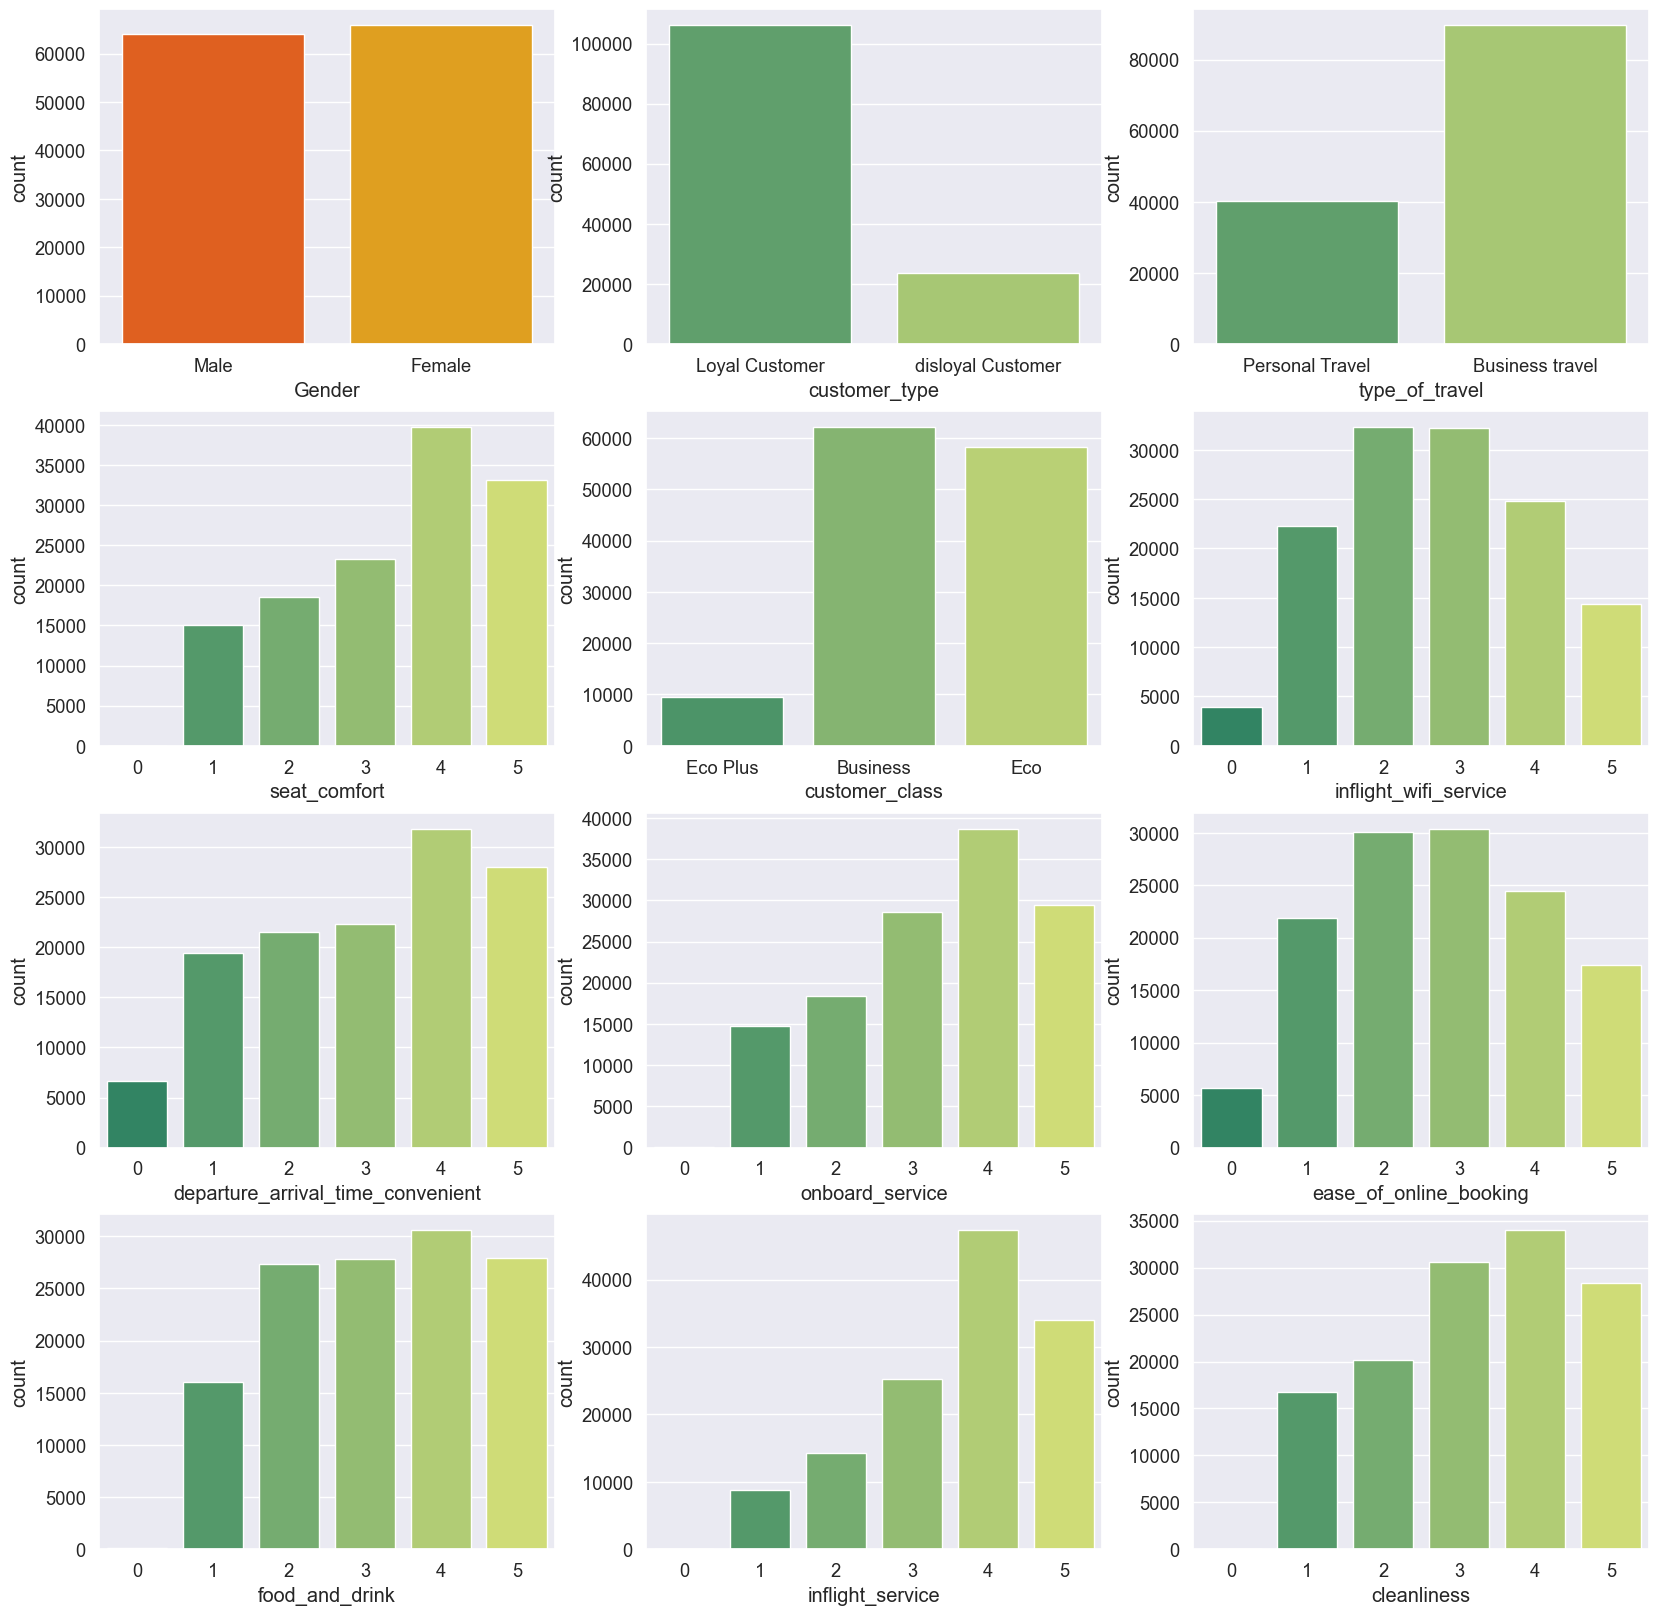

In [32]:


#  https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

fig, axes = plt.subplots(4, 3, figsize = (20, 20))
sns.countplot(x = 'Gender', data = df, palette= 'autumn', ax = axes[0, 0]);
sns.countplot(x = 'customer_type', data = df, palette= 'summer', ax = axes[0, 1]);
sns.countplot(x = 'type_of_travel', data = df,  palette= 'summer', ax = axes[0, 2]);
sns.countplot(x = 'seat_comfort', data = df,  palette= 'summer', ax = axes[1, 0]);
sns.countplot(x = 'customer_class', data = df,  palette= 'summer', ax = axes[1, 1]);
sns.countplot(x = 'inflight_wifi_service', data = df,  palette= 'summer', ax = axes[1, 2]);
sns.countplot(x = 'departure_arrival_time_convenient', data = df,  palette= 'summer', ax = axes[2, 0]);
sns.countplot(x = 'onboard_service', data = df,  palette= 'summer', ax = axes[2, 1]);
sns.countplot(x = 'ease_of_online_booking', data = df,  palette= 'summer', ax = axes[2, 2]);
sns.countplot(x = 'food_and_drink', data = df,  palette= 'summer', ax = axes[3, 0]);
sns.countplot(x = 'inflight_service', data = df,   palette= 'summer', ax = axes[3,  1]);
sns.countplot(x = 'cleanliness', data = df,palette= 'summer', ax = axes[3, 2]);

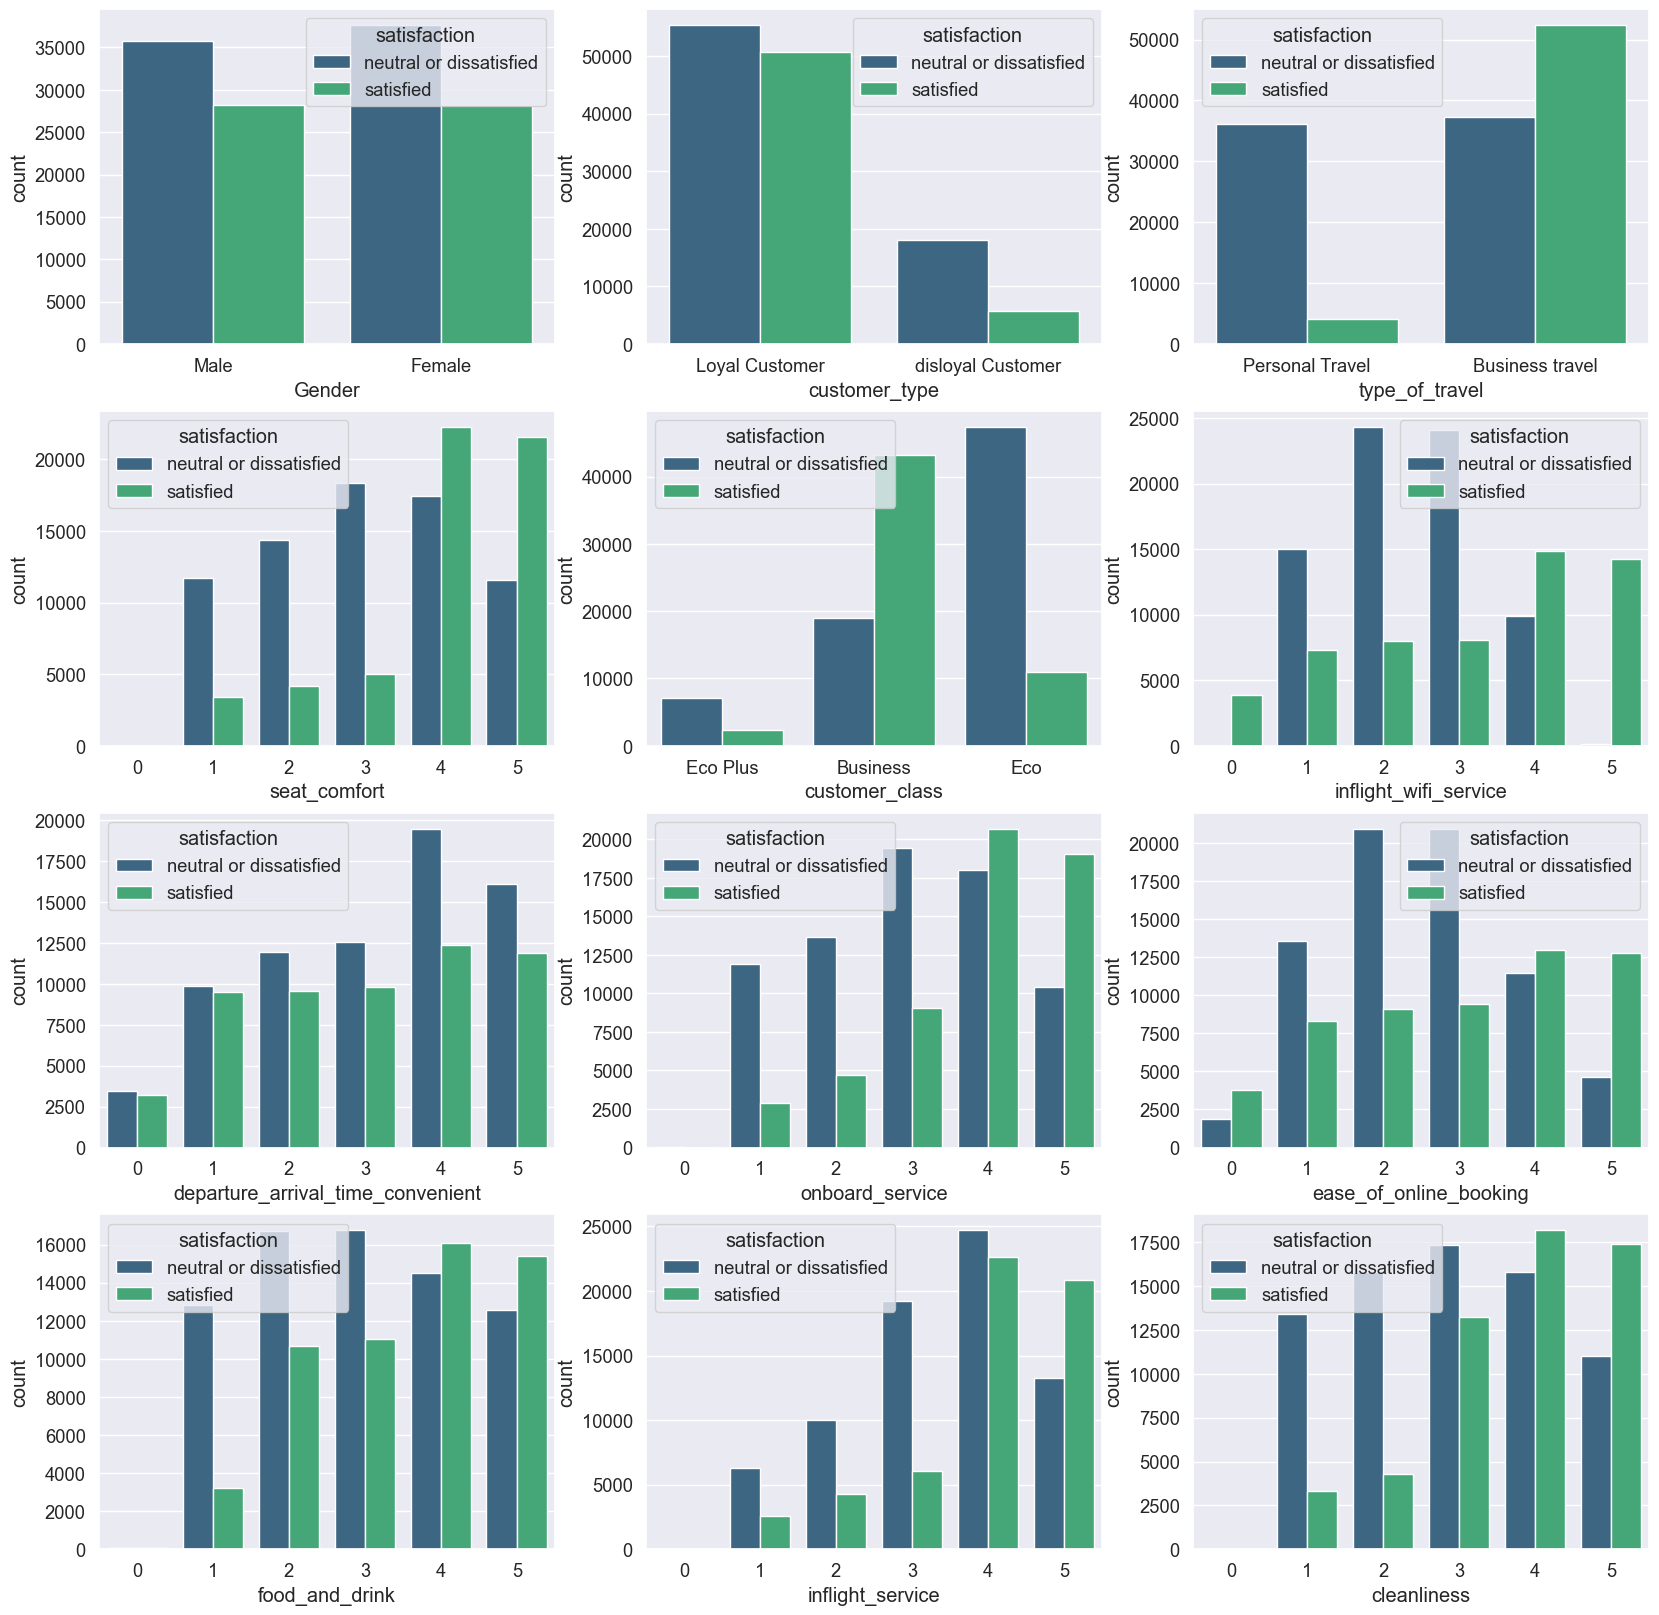

In [28]:


#  https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

fig, axes = plt.subplots(4, 3, figsize = (20, 20))
sns.countplot(x = 'Gender', data = df, hue= 'satisfaction', palette= 'viridis', ax = axes[0, 0]);
sns.countplot(x = 'customer_type', data = df, hue= 'satisfaction', palette= 'viridis', ax = axes[0, 1]);
sns.countplot(x = 'type_of_travel', data = df, hue= 'satisfaction',  palette= 'viridis', ax = axes[0, 2]);
sns.countplot(x = 'seat_comfort', data = df, hue= 'satisfaction',  palette= 'viridis', ax = axes[1, 0]);
sns.countplot(x = 'customer_class', data = df, hue= 'satisfaction',  palette= 'viridis', ax = axes[1, 1]);
sns.countplot(x = 'inflight_wifi_service', data = df, hue= 'satisfaction',  palette= 'viridis', ax = axes[1, 2]);
sns.countplot(x = 'departure_arrival_time_convenient', data = df, hue= 'satisfaction',  palette= 'viridis', ax = axes[2, 0]);
sns.countplot(x = 'onboard_service', data = df, hue= 'satisfaction',  palette= 'viridis', ax = axes[2, 1]);
sns.countplot(x = 'ease_of_online_booking', data = df, hue= 'satisfaction',  palette= 'viridis', ax = axes[2, 2]);
sns.countplot(x = 'food_and_drink', data = df, hue= 'satisfaction',  palette= 'viridis', ax = axes[3, 0]);
sns.countplot(x = 'inflight_service', data = df, hue= 'satisfaction',  palette= 'viridis', ax = axes[3,  1]);
sns.countplot(x = 'cleanliness', data = df, hue= 'satisfaction',  palette= 'viridis', ax = axes[3, 2]);

<AxesSubplot:>

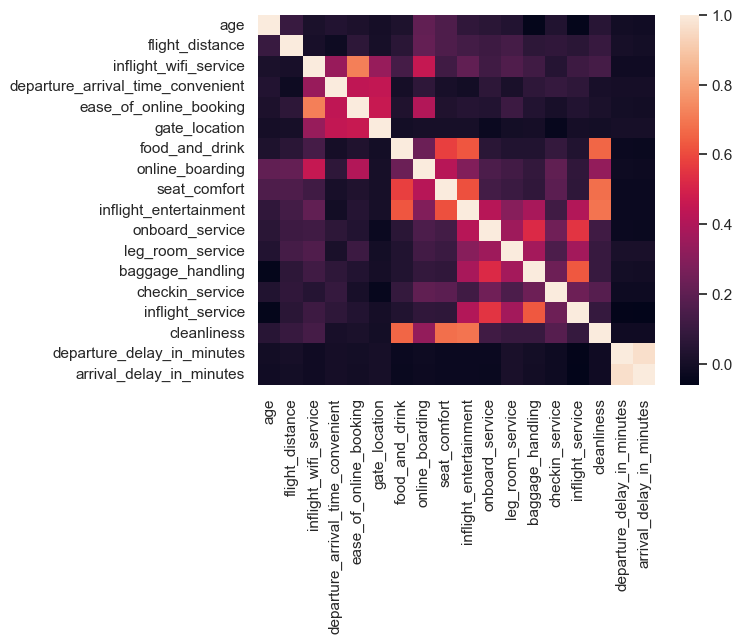

In [13]:
sns.heatmap(df.corr())

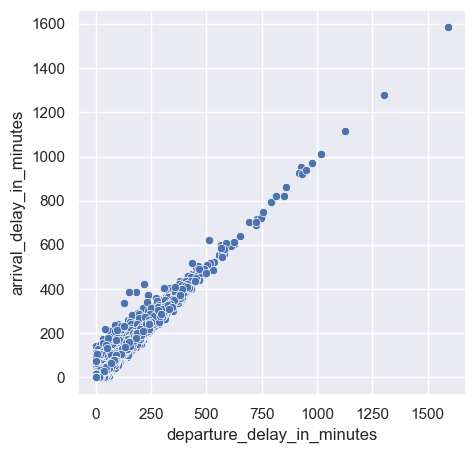

In [14]:
# Departure Delay and Arrival delay are heavily correlated with each other, therefore one of them should be dropped
plt.figure(figsize = (5, 5))
sns.scatterplot(x = 'departure_delay_in_minutes', y = 'arrival_delay_in_minutes', data = df)
plt.show()

In [15]:
# calcuate dissatisfied_rate
# pivot_satisfaction(df,"Inflight service")

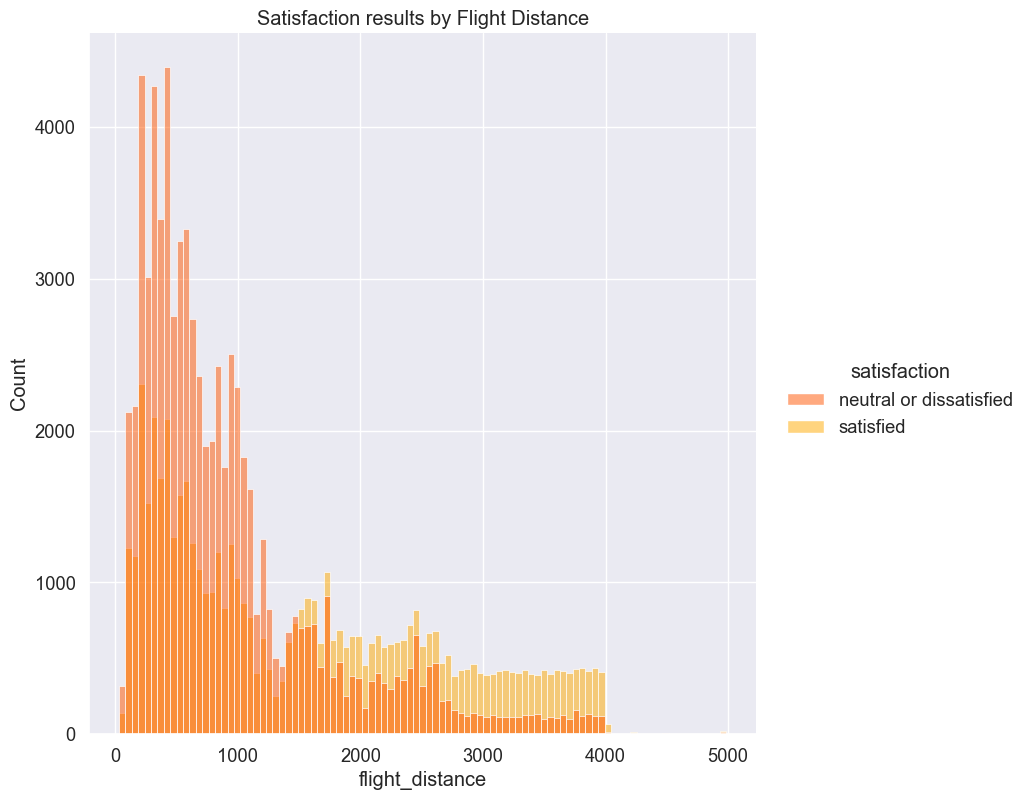

In [38]:
# create graph
sns.displot(x = "flight_distance", data = df, hue ="satisfaction", height = 8,palette ="autumn"  )
plt.title("Satisfaction results by Flight Distance")


plt.show()


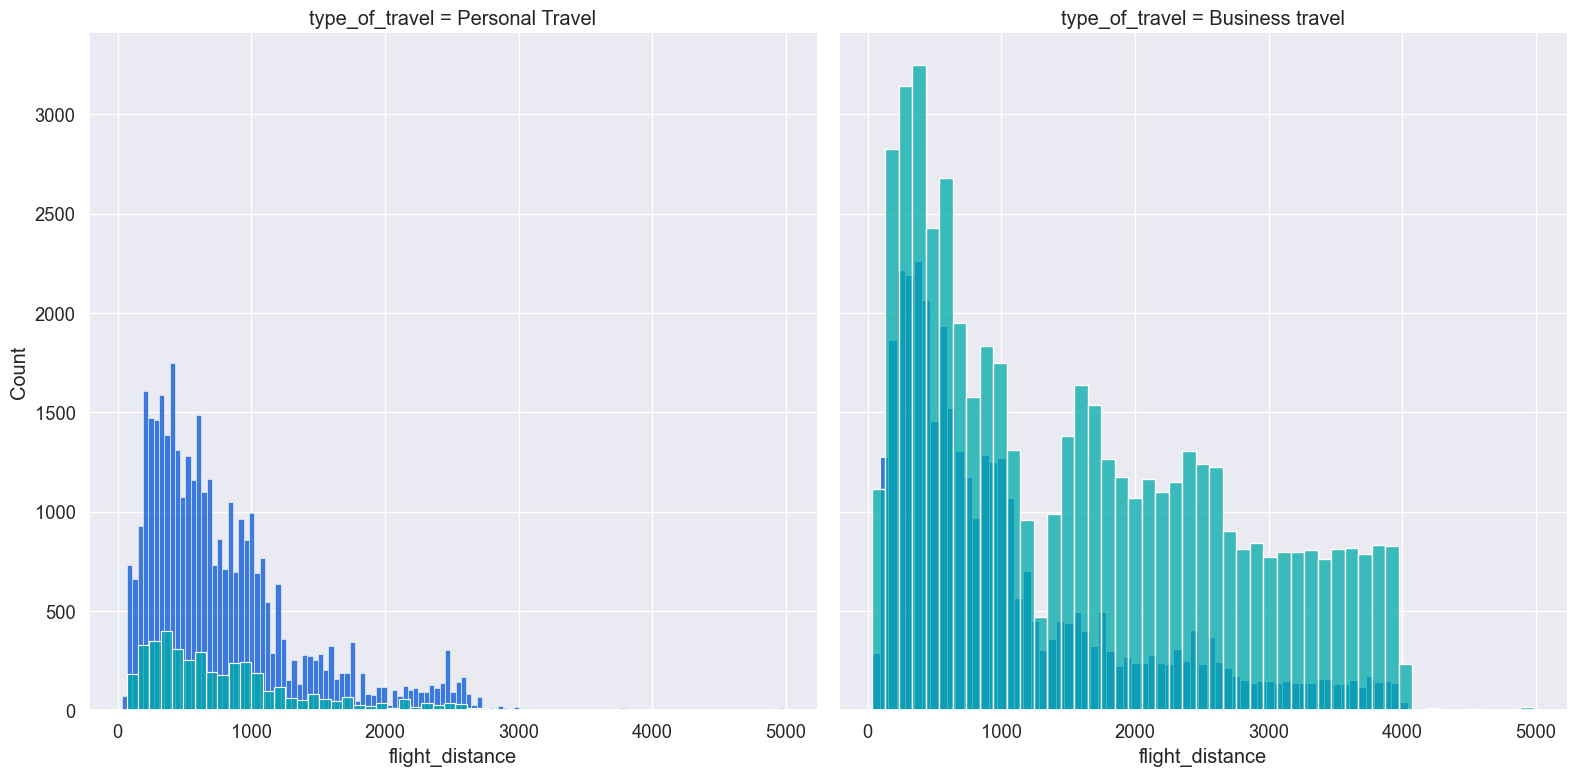

In [37]:
# create graph
g = sns.FacetGrid(df, col = "type_of_travel", hue ="satisfaction", height = 8, palette ="winter" )
g.map(sns.histplot, "flight_distance",  )
plt.show()

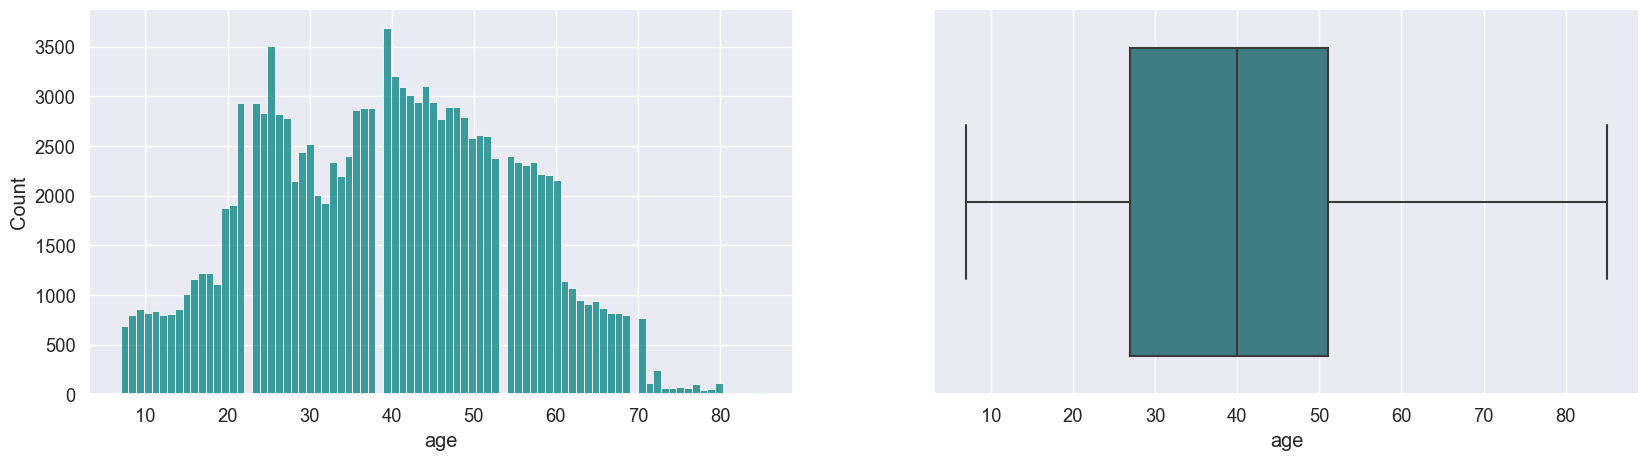

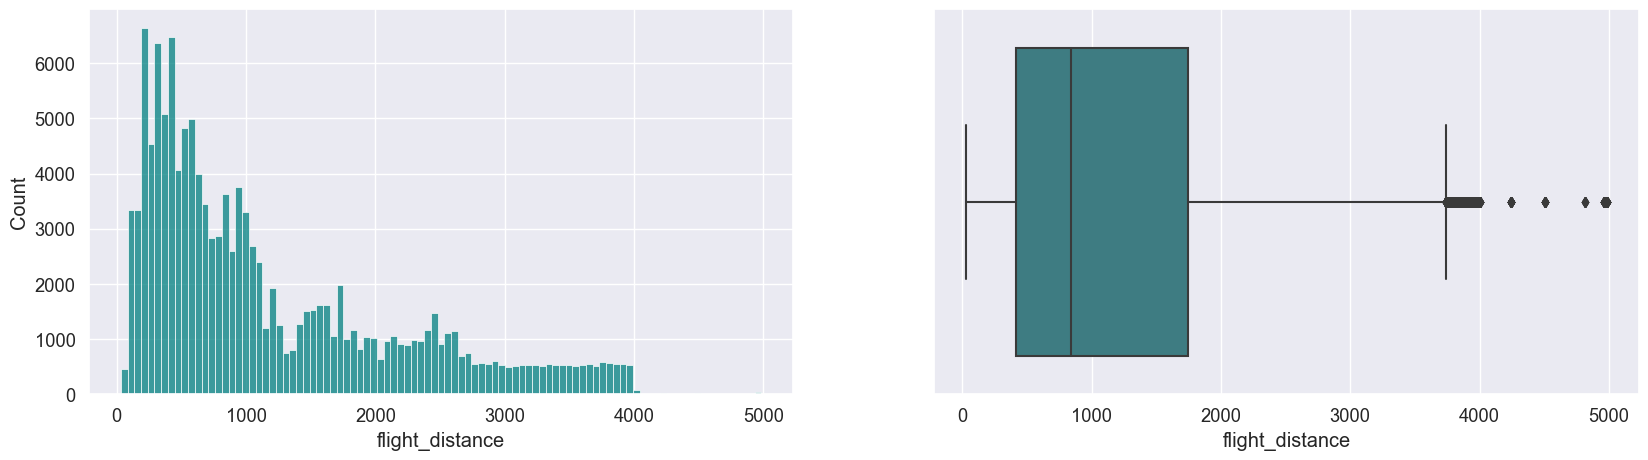

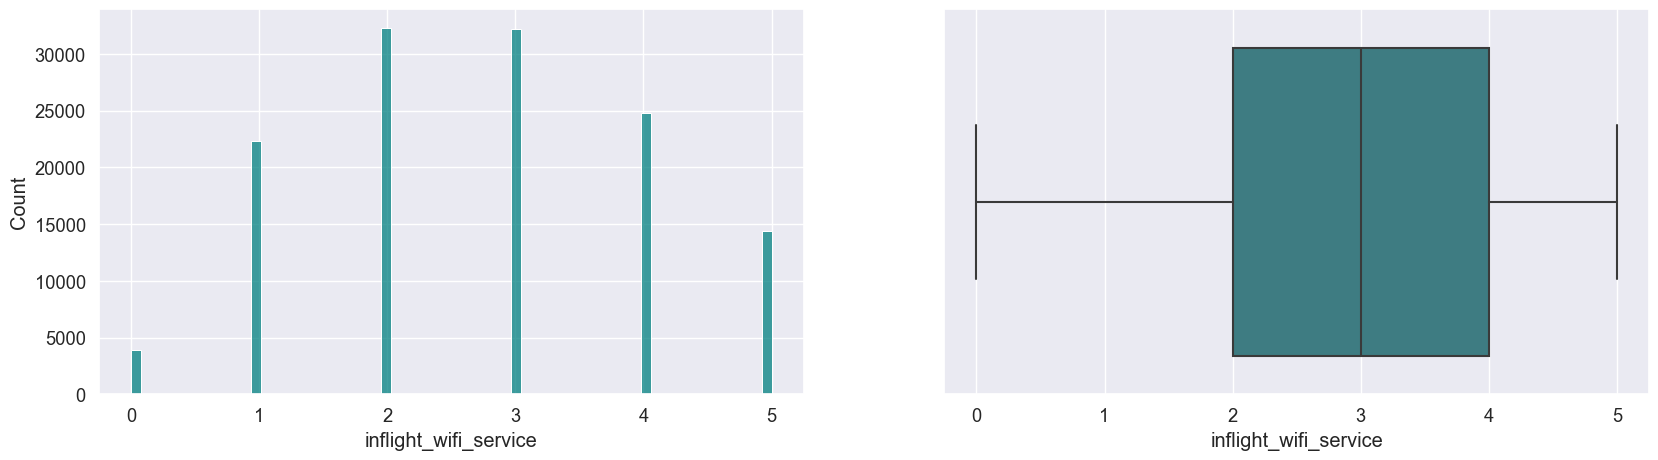

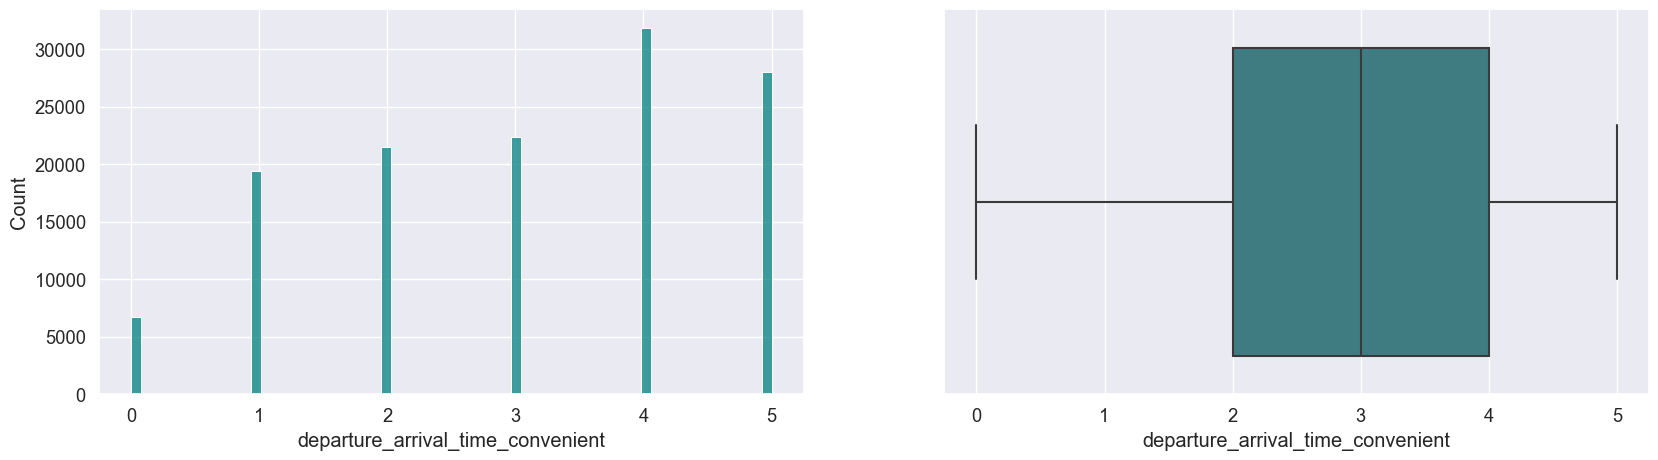

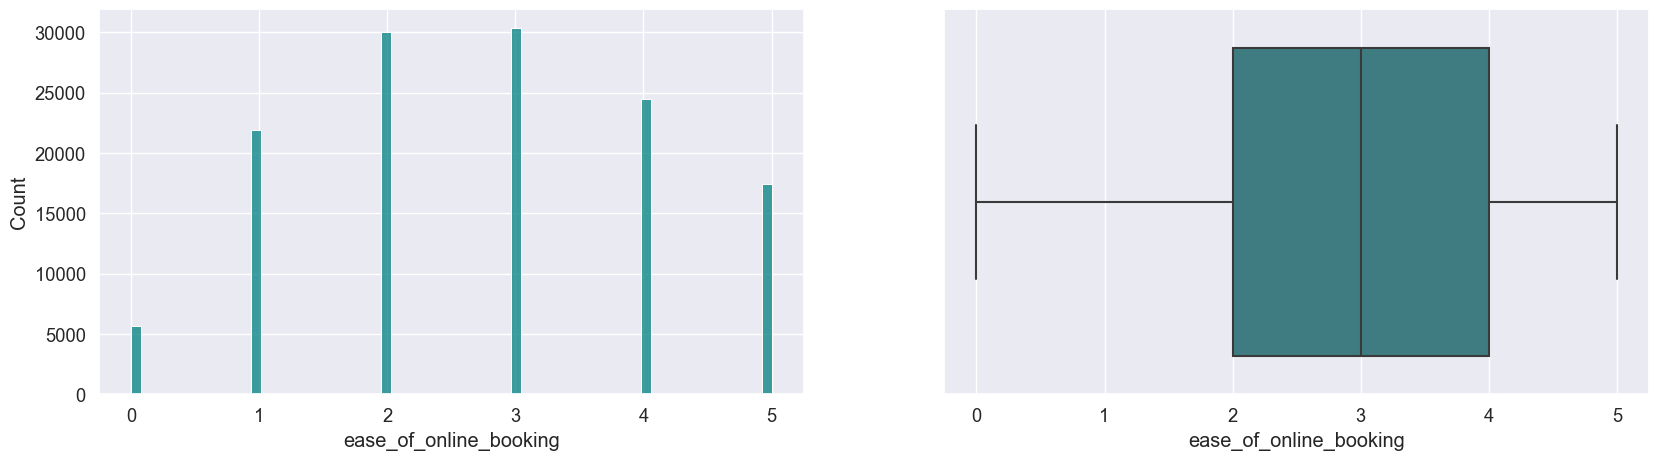

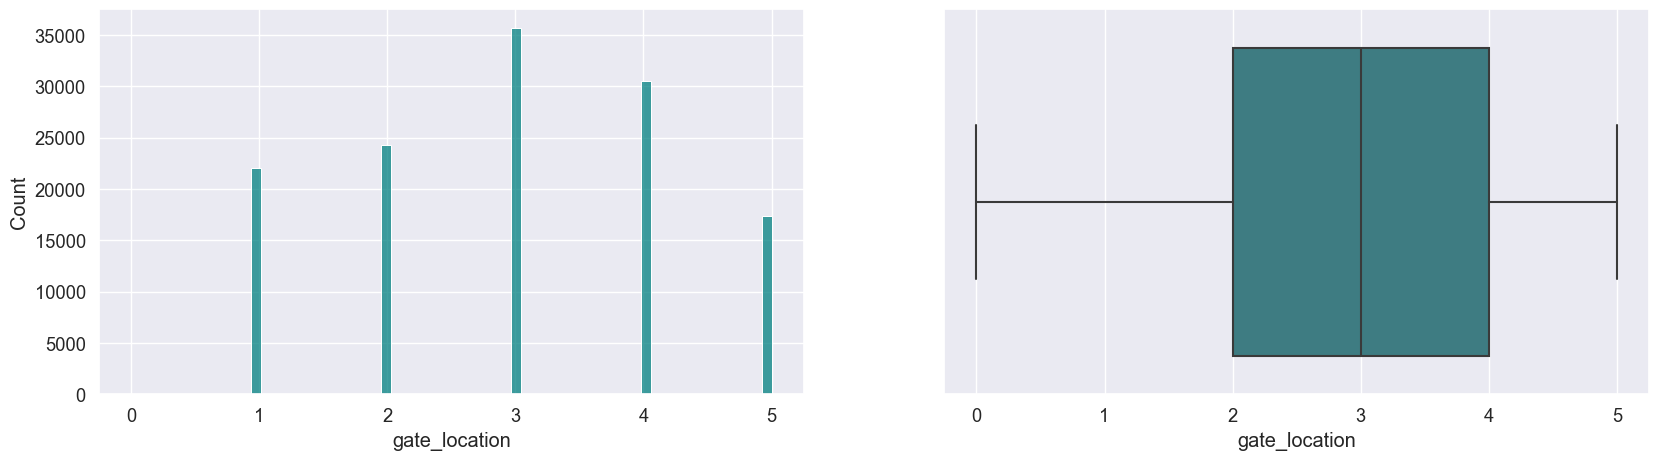

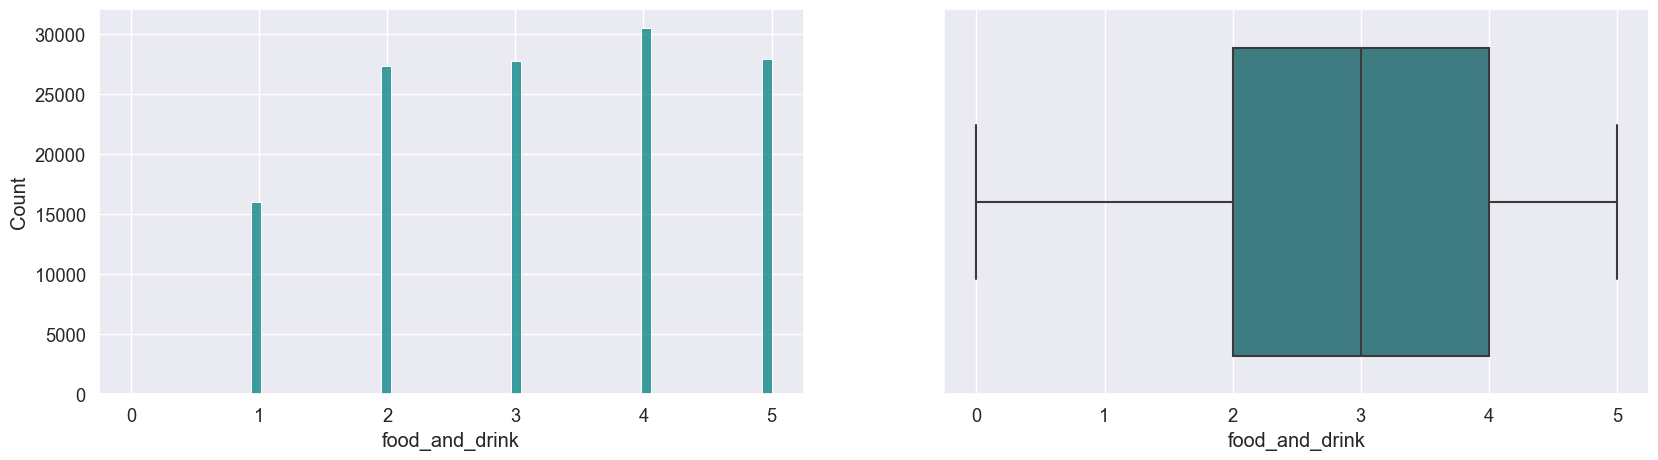

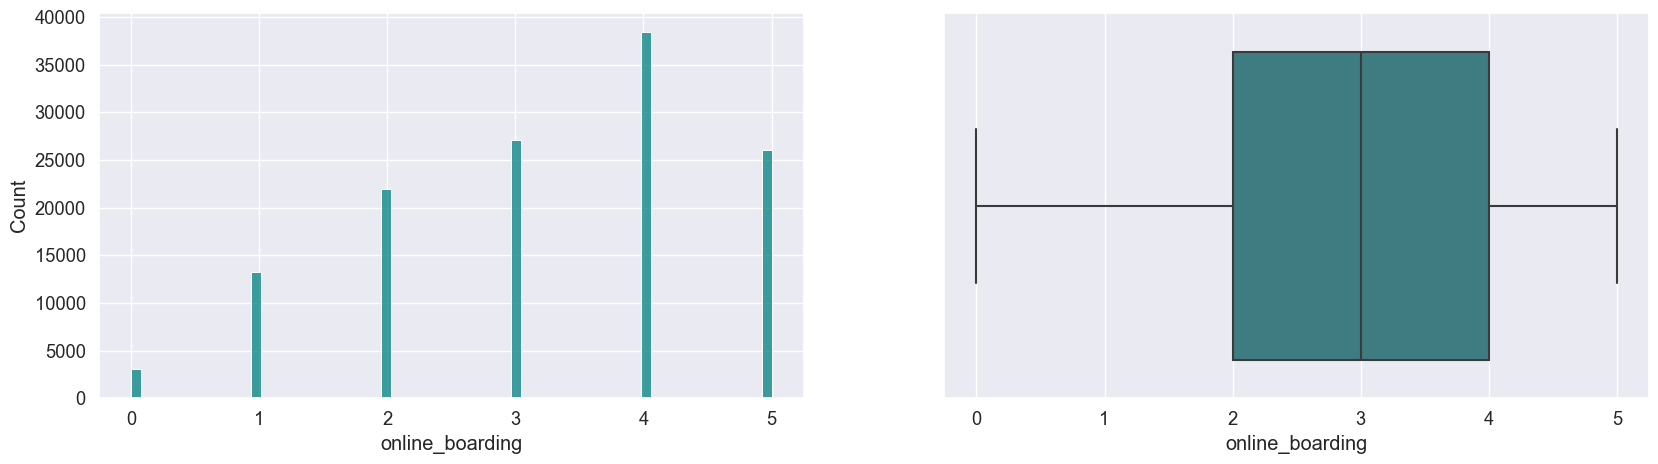

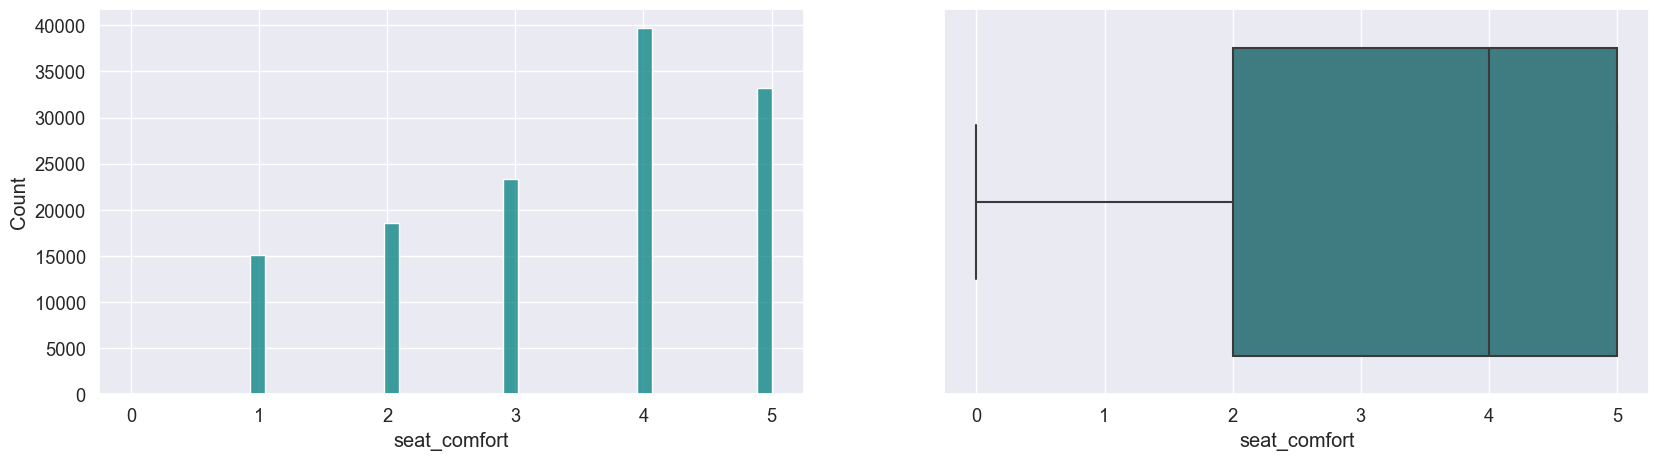

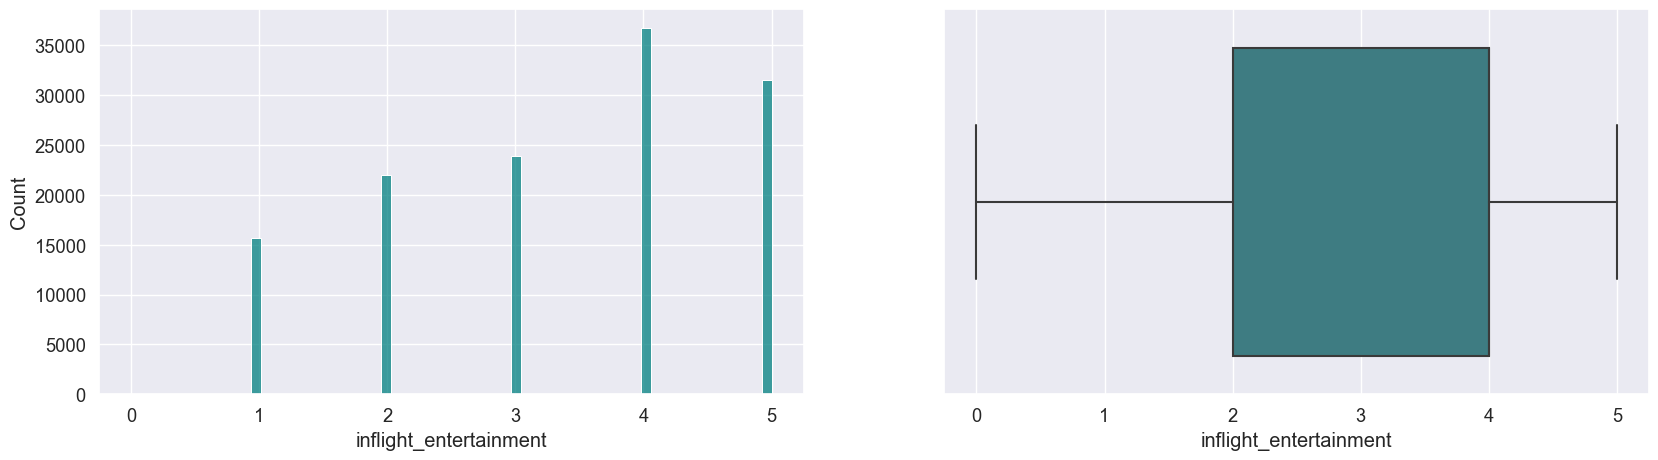

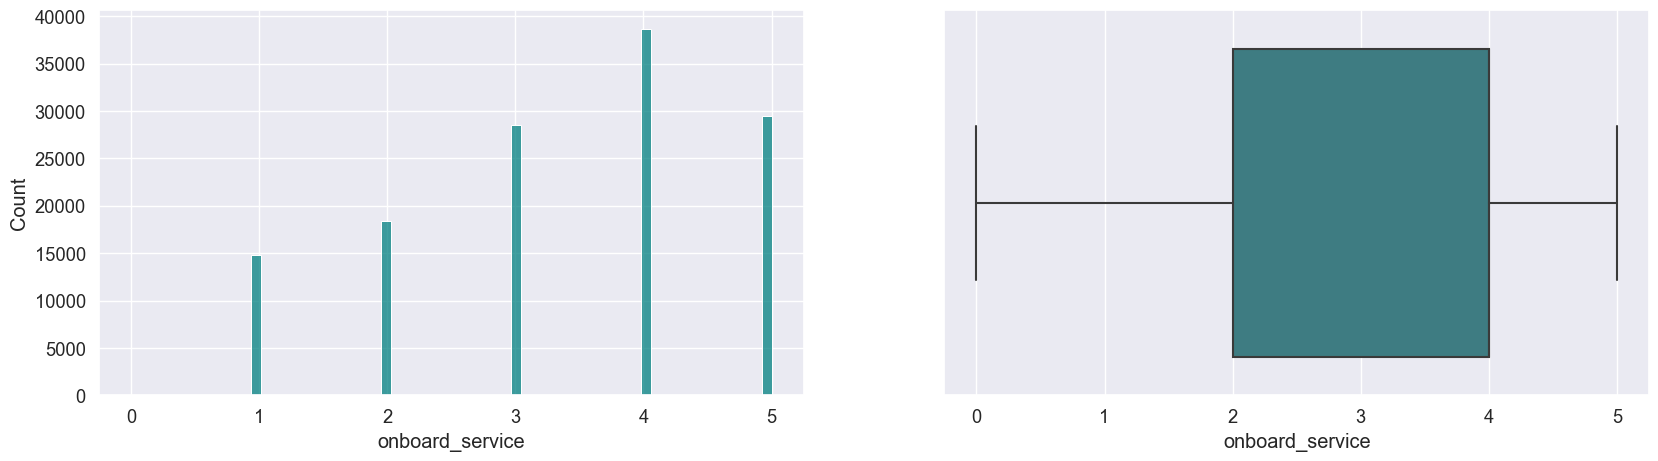

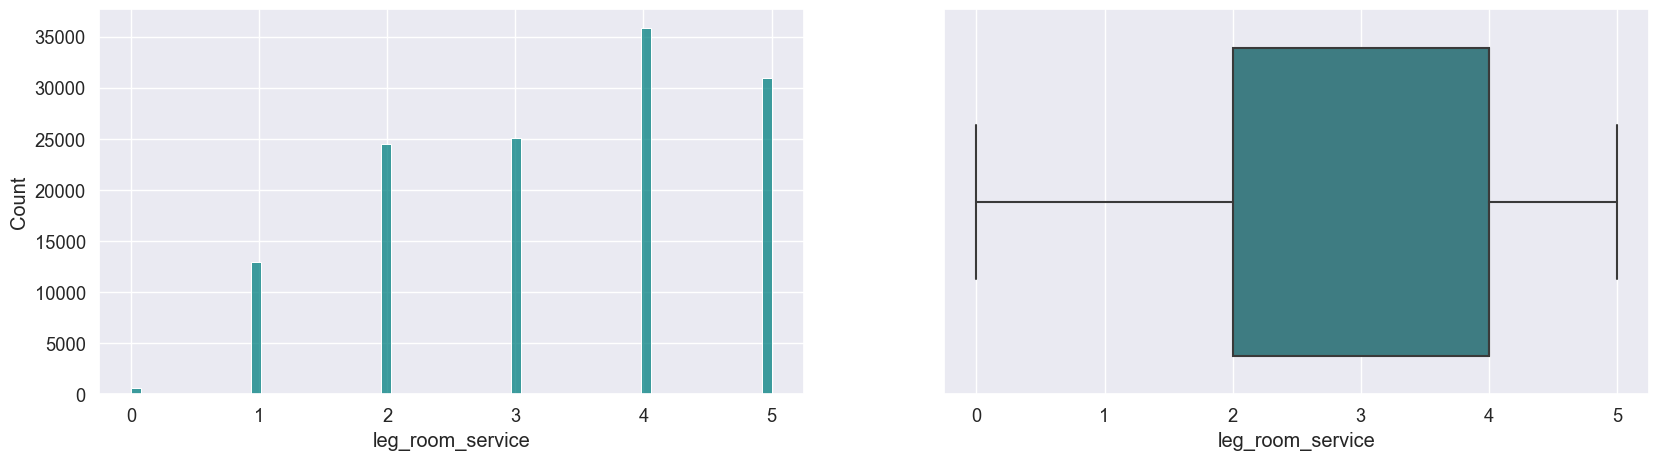

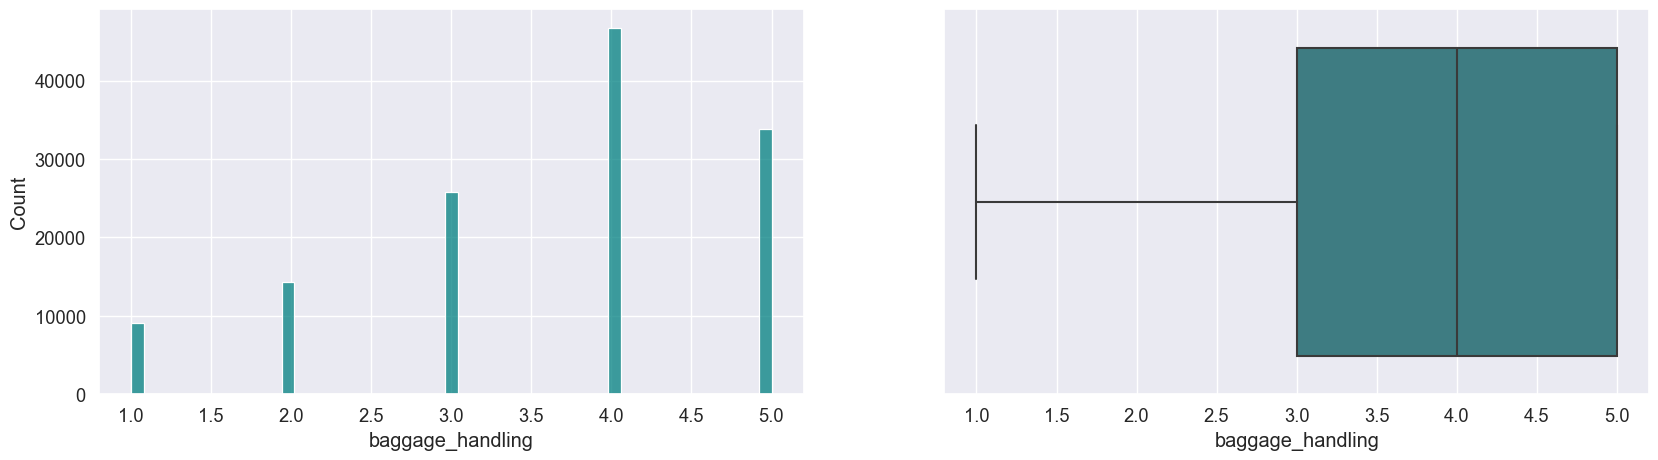

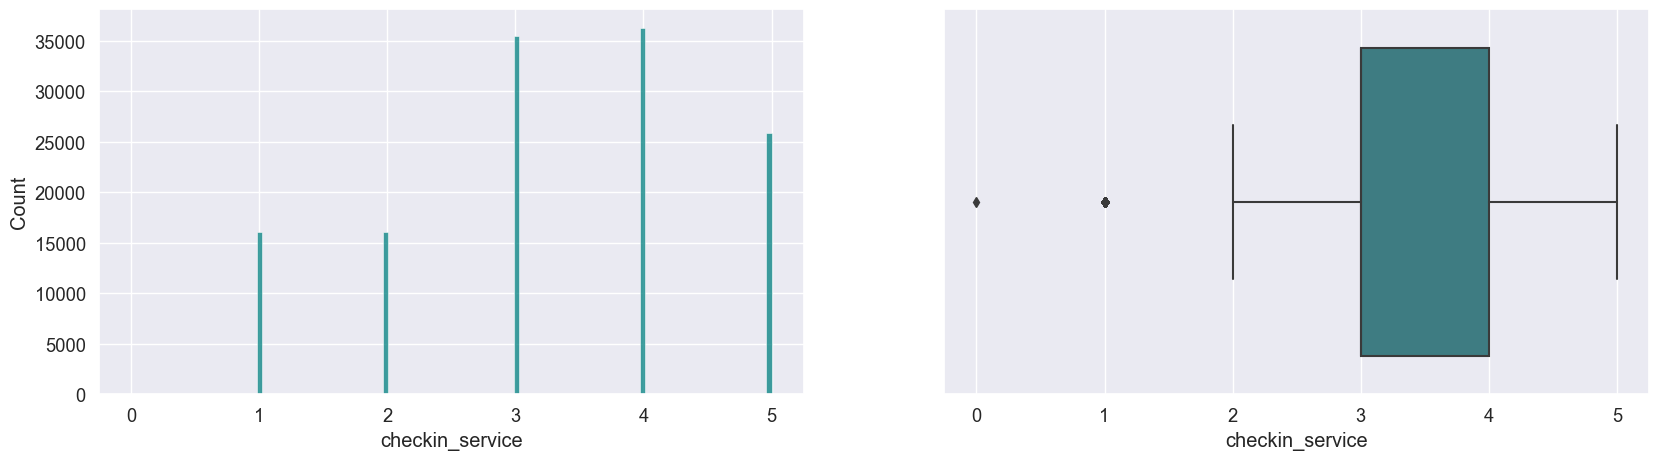

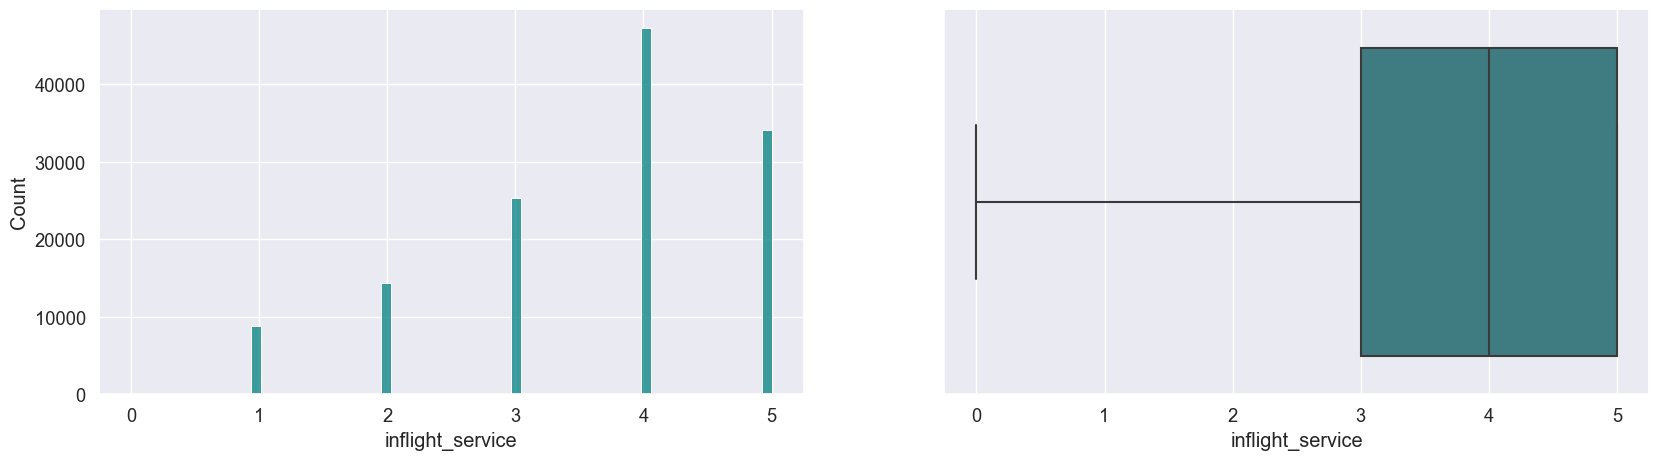

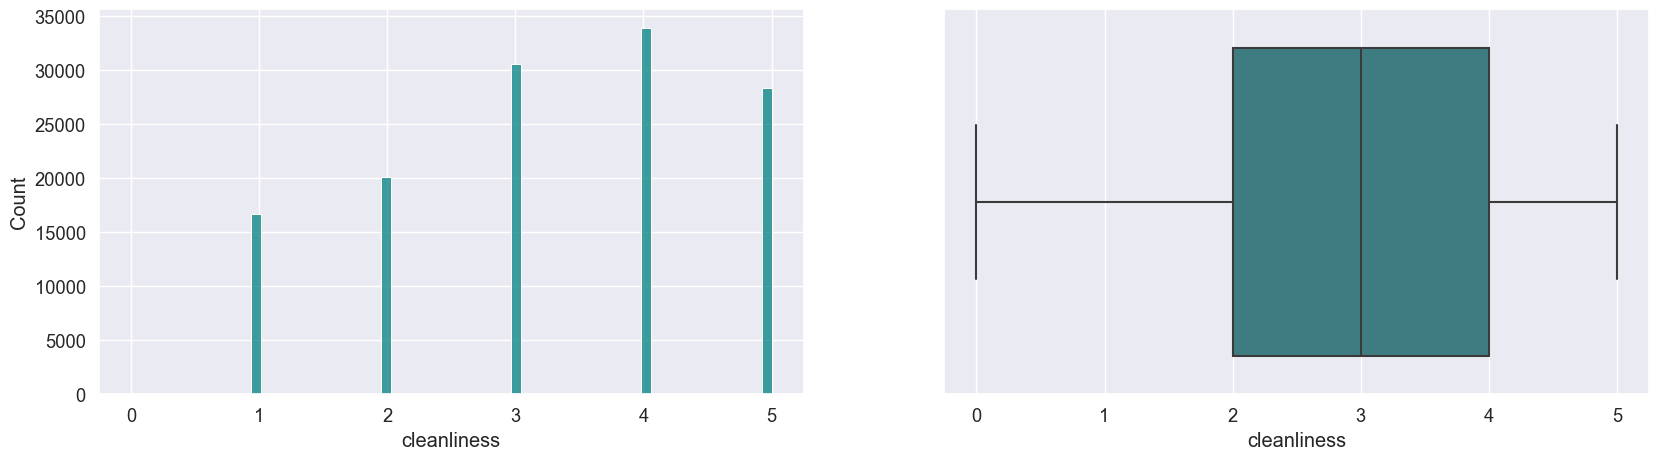

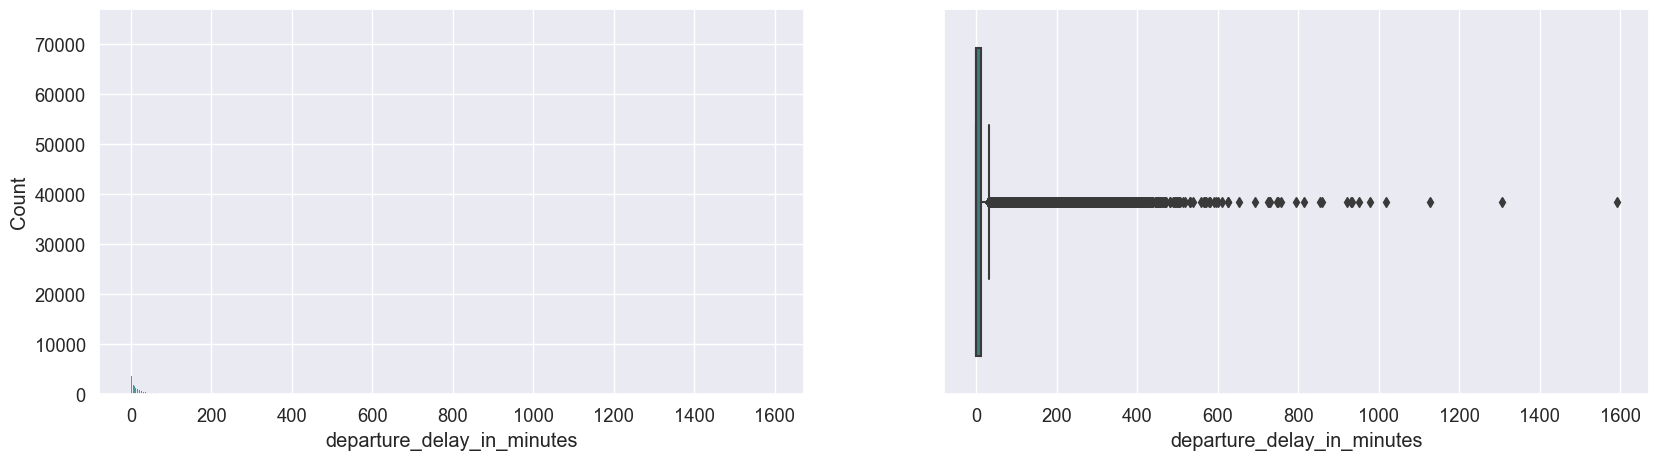

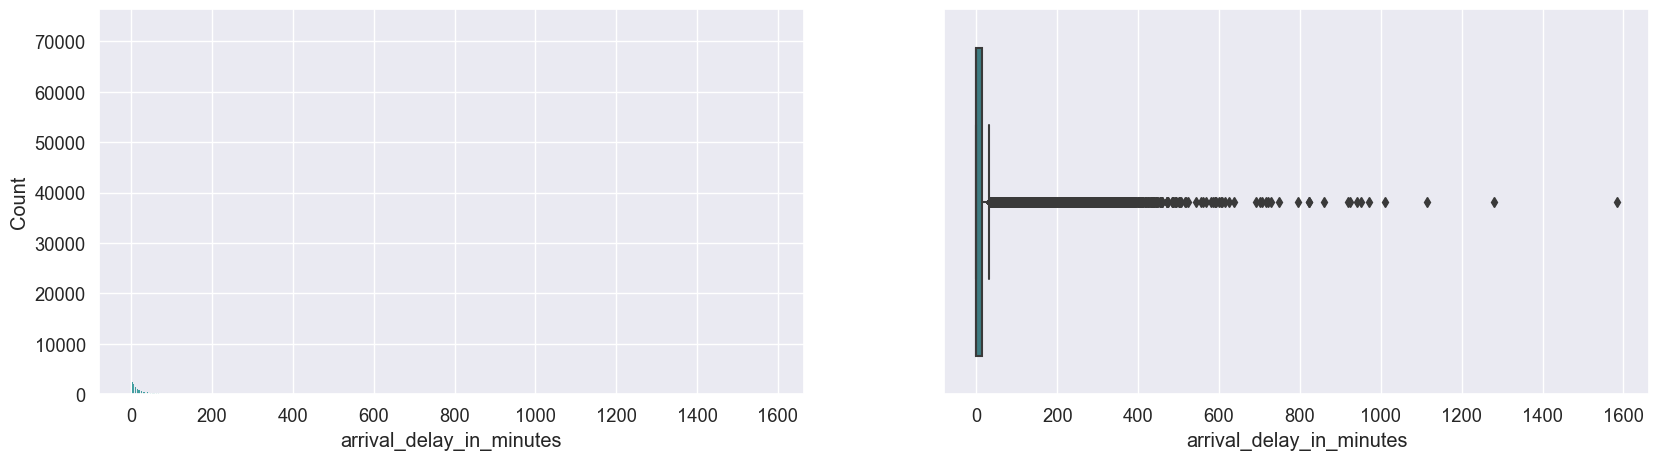

In [43]:
# https://www.kaggle.com/code/anubhavgoyal10/airline-passenger-satisfaction-knn/notebook
sns.set_context('notebook', font_scale= 1.2)
for col in numerical_variables:
    fig, ax = plt.subplots(1, 2, figsize = (20, 5))
    sns.histplot(df[col], ax = ax[0], color= 'teal')
    sns.boxplot(x = df[col], ax= ax[1], palette= 'crest')